<a href="https://colab.research.google.com/github/rashwinr/MONAI_tutorials/blob/main/MEDMNIST_Pneumonia_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MEDMNIST Pneumonia Classification

Objectives:
Develop a medical image classification algorithm that enables accurate prediction of pneumonia in chest X-ray.


## Installing MONAI

In [ ]:
!pip show monai

In [ ]:
!pip install monai[all]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8

## Download Data

In [ ]:
!pip install medmnist

In [ ]:
from medmnist import PneumoniaMNIST

In [ ]:
import os
dir_path = os.getcwd()
print(dir_path)

/content


In [ ]:
data_train = PneumoniaMNIST(root=dir_path, split='train',download=True)
data_val = PneumoniaMNIST(split='val', download=True)
data_test = PneumoniaMNIST(split='test', download=True)

100%|██████████| 4.17M/4.17M [00:00<00:00, 4.36MB/s]


100%|██████████| 4.17M/4.17M [00:00<00:00, 4.51MB/s]

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


In [ ]:
print(data_train.info)

{'python_class': 'PneumoniaMNIST', 'description': 'The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.', 'url': 'https://zenodo.org/records/10519652/files/pneumoniamnist.npz?download=1', 'MD5': '28209eda62fecd6e6a2d98b1501bb15f', 'url_64': 'https://zenodo.org/records/10519652/files/pneumoniamnist_64.npz?download=1', 'MD5_64': '8f4eceb4ccffa70c672198ea285246c6', 'url_128': 'https://zenodo.org/records/10519652/files/pneumoniamnist_128.npz?download=1', 'MD5_128': '05b46931834c231683c68f40c47b2971', 'url_224': 'https://zenodo.org/records/10519652/files/pneumoniamnist_224.npz?download=1', 'MD5_224': 'd6a3c71de1b945ea11211b

In [ ]:
!unzip /content/pneumoniamnist.npz -d /content/pneumoniamnist

Archive:  /content/pneumoniamnist.npz
  inflating: /content/pneumoniamnist/train_images.npy  
  inflating: /content/pneumoniamnist/val_images.npy  
  inflating: /content/pneumoniamnist/test_images.npy  
  inflating: /content/pneumoniamnist/train_labels.npy  
  inflating: /content/pneumoniamnist/val_labels.npy  
  inflating: /content/pneumoniamnist/test_labels.npy  


In [ ]:

data_dir="/content/pneumoniamnist"
print(data_dir)

for files in os.listdir(data_dir):
    print(files)

/content/pneumoniamnist
test_labels.npy
val_images.npy
train_labels.npy
train_images.npy
val_labels.npy
test_images.npy


## Data preparation

* Below cell prints the total number of classes in train dataset, class names, and the number of images per class.

In [ ]:
import numpy as np

train_images = np.load('/content/pneumoniamnist/train_images.npy')
train_label = np.load('/content/pneumoniamnist/train_labels.npy')

print("train_images shape:", train_images.shape)
print("train_labels shape:", train_label.shape)

train_images shape: (4708, 28, 28)
train_labels shape: (4708, 1)


In [ ]:
from monai.data import Dataset                                      # Prepare data for MONAI Dataset

train_files = [{'image': img} for img in train_images]
print(len(train_files))

train_dataset = Dataset(data=train_files, transform=None)           # Create a MONAI Dataset

4708


In [ ]:
print(f"The length of train dataset is: {len(train_dataset)}")
print(f"The size of the image is: {train_dataset[0]['image'].shape} with type {type(train_dataset[0]['image'])}")

The length of train dataset is: 4708
The size of the image is: (28, 28) with type <class 'numpy.ndarray'>


### Data Visualization

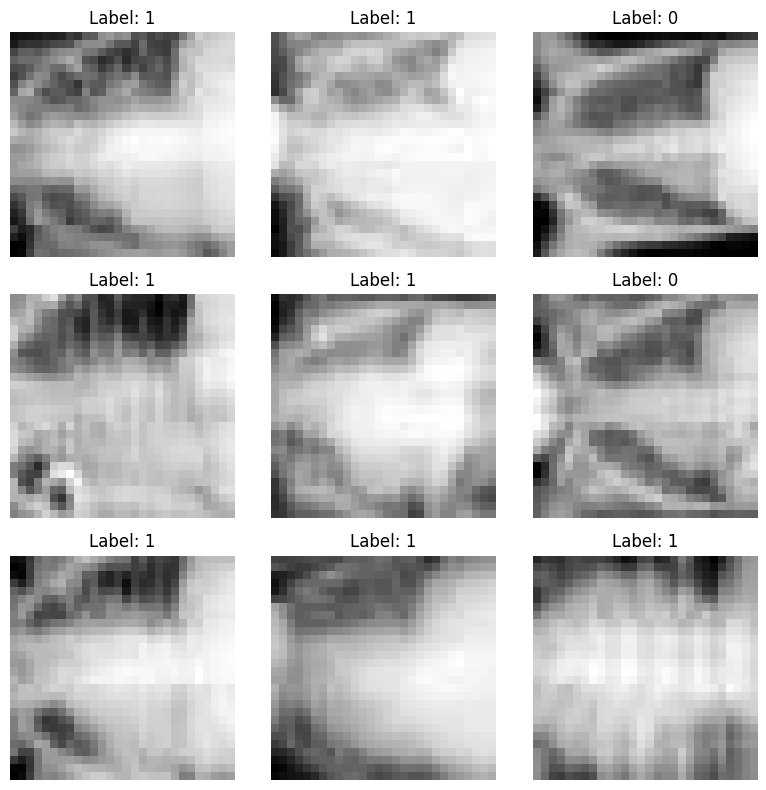

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Select 9 random images from the training dataset
random_indices = random.sample(range(len(train_dataset)), 9)
images = [train_dataset[i]['image'] for i in random_indices]
labels = [train_label[i].item() for i in random_indices]  # Assuming train_label contains labels

# Create a 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

# Plot each image in the subplot with title
for i, ax in enumerate(axes.flat):
    ax.imshow(np.transpose(images[i]), cmap='gray')
    ax.set_title(f"Label: {labels[i]}")  # Add title with label
    ax.axis('off')

plt.tight_layout()
plt.show()

### Data distribution

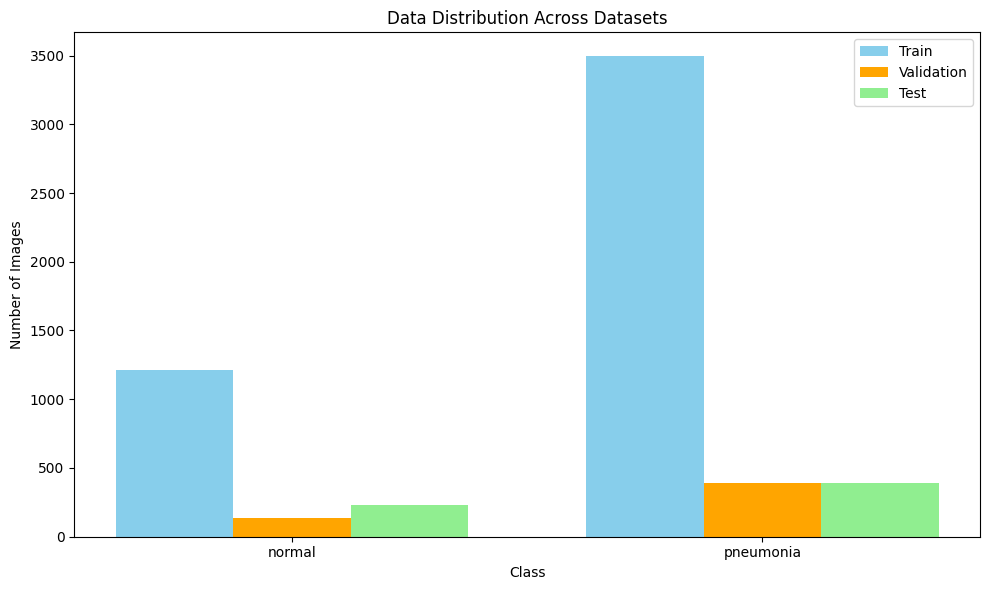

In [ ]:
# Count the occurrences of each class in the training set
train_class_counts = np.bincount(train_label.flatten().astype(int))

# Assuming class 0 is 'normal' and class 1 is 'pneumonia'
class_names = ['normal', 'pneumonia']


# Repeat the process for validation and test sets
val_labels = np.load('/content/pneumoniamnist/val_labels.npy')
test_labels = np.load('/content/pneumoniamnist/test_labels.npy')

val_class_counts = np.bincount(val_labels.flatten().astype(int))
test_class_counts = np.bincount(test_labels.flatten().astype(int))

import matplotlib.pyplot as plt
import numpy as np

# ... (your existing code to load and process data) ...

# Define bar width and positions
bar_width = 0.25
x_positions = np.arange(len(class_names))

# Create the bar plot
plt.figure(figsize=(10, 6))

plt.bar(x_positions - bar_width, train_class_counts, width=bar_width, label='Train', color='skyblue')
plt.bar(x_positions, val_class_counts, width=bar_width, label='Validation', color='orange')
plt.bar(x_positions + bar_width, test_class_counts, width=bar_width, label='Test', color='lightgreen')

# Set labels, title, and legend
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Data Distribution Across Datasets')
plt.xticks(x_positions, class_names)  # Set x-axis tick labels
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

### Transforms

In [ ]:
from monai.transforms import (
    Compose,
    LoadImaged,  # Import LoadImaged for dictionary-based input
    RandRotate,
    RandFlip,
    ToTensor,
    EnsureChannelFirstd, # Use EnsureChannelFirstd to work with dictionary
    ScaleIntensityd, # Use ScaleIntensityd to work with dictionary
    EnsureTyped, # Add this
    Resized,
    BorderPadd # Use BorderPadd for dictionary-based input
)
from monai.data import Dataset, NumpyReader

# Define transforms for training data
train_transforms = Compose([
    ToTensor(),
    EnsureChannelFirstd(keys=['image'], channel_dim="no_channel"),  # Add channel dimension to the image data using the 'image' key
    ScaleIntensityd(keys=['image']),  # Rescale image pixel values using the 'image' key
    EnsureTyped(keys=['image']),
    # Resized(keys=["image"],spatial_size=(32,32)),
    BorderPadd(keys=["image"],spatial_border=[2, 2]), # Use a list of two integers for padding (height, width) or a single integer for both.
    ToTensor(),
])

train_ds = Dataset(data=train_dataset, transform=train_transforms)
train_label = np.load('/content/pneumoniamnist/train_labels.npy')
train_label = ToTensor()(train_label)

In [ ]:
print(f"The length of train dataset is: {len(train_ds)}")
print(f"The size of the image is: {train_ds[0]['image'].shape} with type {type(train_ds[0]['image'])}")
print(f"The size of the label is: {train_label.shape} with type {type(train_label)}")

The length of train dataset is: 4708
The size of the image is: torch.Size([1, 32, 32]) with type <class 'monai.data.meta_tensor.MetaTensor'>
The size of the label is: torch.Size([4708, 1]) with type <class 'monai.data.meta_tensor.MetaTensor'>


In [ ]:
val_images = np.load('/content/pneumoniamnist/val_images.npy')
val_labels = np.load('/content/pneumoniamnist/val_labels.npy')

val_files = [{'image': img} for img in val_images]

val_transforms = Compose([
    ToTensor(),
    EnsureChannelFirstd(keys=['image'], channel_dim="no_channel"),
    ScaleIntensityd(keys=['image']),
    EnsureTyped(keys=['image']),
    # Resized(keys=["image"],spatial_size=(32,32)),
    BorderPadd(keys=["image"],spatial_border=[2,2]), # Changed BorderPad to BorderPadd
])

val_ds = Dataset(data=val_files, transform=val_transforms)
val_label = np.load('/content/pneumoniamnist/val_labels.npy')
val_label = ToTensor()(val_label)

In [ ]:
print(f"The length of val dataset is: {len(val_ds)}")
print(f"The size of the image is: {val_ds[0]['image'].shape} with type {type(val_ds[0]['image'])}")
print(f"The size of the label is: {val_label.shape} with type {type(val_label)}")

The length of val dataset is: 524
The size of the image is: torch.Size([1, 32, 32]) with type <class 'monai.data.meta_tensor.MetaTensor'>
The size of the label is: torch.Size([524, 1]) with type <class 'monai.data.meta_tensor.MetaTensor'>


### DataLoader

In [ ]:
from monai.data import DataLoader
import numpy as np
import torch

In [ ]:
train_loader = DataLoader(
    dataset=list(zip(train_ds, train_label)),  # Use zip to create pairs of (image, label)
    batch_size=32,
    shuffle=True,
    num_workers=2
)

In [ ]:
print(len(train_loader))

# Iterate through the DataLoader using a for loop
for batch_data in train_loader:
    # Access the batch data (images and labels)
    images, labels = batch_data
    # Now you can print or process the data in the batch
    print(images['image'].shape, labels.shape)  # Example: print the shape of images and labels
    break  # Exit the loop after processing the first batch

148
torch.Size([32, 1, 32, 32]) torch.Size([32, 1])


In [ ]:
val_loader = DataLoader(
    dataset=list(zip(val_ds, val_label)),
    batch_size=32,
    shuffle=False,
    num_workers=2
)

## Model and parameters

In [ ]:
from monai.networks.nets import DenseNet
from monai.losses import DiceCELoss
from monai.metrics import ROCAUCMetric
import sklearn

device= torch.device("cuda" if torch.cuda.is_available() else 'cpu')
if(device == "cpu"): print("using CPU")

model = DenseNet(spatial_dims=2, in_channels=1, out_channels=2).to(device)     #Declare the model
loss_function=DiceCELoss(to_onehot_y=True,lambda_dice=0,lambda_ce=1)           #Loss function declaration
optimizer= torch.optim.Adam(model.parameters(), 1e-3)
max_epochs=5
val_interval=1
auc_metric = ROCAUCMetric()
class_names = ['normal', 'pneumonia']

from monai.transforms import AsDiscrete, Activations
y_pred_trans = Activations(softmax=True)                          #added y_pred_trans for softmax
y_trans = AsDiscrete(to_onehot=2)                                 #added y_trans for one_hot

## Training & Validation

* Below cell trains model on train dataset and validate the model on validation dataset.

In [ ]:
from monai.data import decollate_batch
from sklearn.metrics import accuracy_score
from tqdm import tqdm
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []



for epoch in range(max_epochs):                                                                   #Iteration of for loop through multiple epochs
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in tqdm(train_loader):                                                                              #Iteration of all the data in train loader
        step += 1
        inputs, labels = batch_data
        inputs = inputs["image"].to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)                                                                                 #Predicting the outputs from the model
        loss = loss_function(outputs, labels)                                                                   #Computing the loss for each batch
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")                                                  #Printing the computed loss after training

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:                                                                         #Iteration of all the data in val loader
                val_images, val_labels = val_data[0]["image"].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)                                                                    #Computing the AUROC metric
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            y_pred_class = torch.argmax(y_pred, dim=1)                          # Convert logits to class labels
            acc_metric = accuracy_score(y.cpu().numpy(),y_pred_class.cpu().numpy())                             # Computing the accuracy
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model.pth")
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

----------
epoch 1/5


100%|██████████| 148/148 [02:04<00:00,  1.19it/s]

epoch 1 average loss: 0.1743


saved new best metric model
current epoch: 1 current AUC: 0.9937 current accuracy: 0.9561 best AUC: 0.9937 at epoch: 1
----------
epoch 2/5


100%|██████████| 148/148 [02:05<00:00,  1.18it/s]

epoch 2 average loss: 0.1216


current epoch: 2 current AUC: 0.9923 current accuracy: 0.9561 best AUC: 0.9937 at epoch: 1
----------
epoch 3/5


100%|██████████| 148/148 [03:14<00:00,  1.31s/it]

epoch 3 average loss: 0.1014


current epoch: 3 current AUC: 0.9862 current accuracy: 0.9504 best AUC: 0.9937 at epoch: 1
----------
epoch 4/5


100%|██████████| 148/148 [02:04<00:00,  1.19it/s]

epoch 4 average loss: 0.1270


saved new best metric model
current epoch: 4 current AUC: 0.9943 current accuracy: 0.8912 best AUC: 0.9943 at epoch: 4
----------
epoch 5/5


100%|██████████| 148/148 [02:10<00:00,  1.13it/s]

epoch 5 average loss: 0.1057


current epoch: 5 current AUC: 0.9894 current accuracy: 0.9141 best AUC: 0.9943 at epoch: 4
train completed, best_metric: 0.9943 at epoch: 4


## Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix

# Load the best model
model.load_state_dict(torch.load("/content/best_metric_model.pth"))

#Setting the model to evaluation state
model.eval()


with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader:
        val_images, val_labels = val_data[0]["image"].to(device), val_data[1].to(device)
        y_pred = torch.cat([y_pred, model(val_images)], dim=0)
        y = torch.cat([y, val_labels], dim=0)

print(f"The shape of y_pred is: {y_pred.shape}")
y_pred_class = torch.argmax(y_pred,dim=1)
print(f"The shape of y_pred_class is: {y_pred_class.shape}")
print(f"The shape of y_pred_class is: {y_pred_class.unsqueeze(-1).shape}")
accuracy = accuracy_score(y_pred_class.cpu().numpy(),y.squeeze(-1).cpu().numpy())
print(f"Accuracy on validation set: {accuracy}")
y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
y_pred_onehot = [y_trans(i) for i in decollate_batch(y_pred_class.unsqueeze(-1), detach=False)]
y_onehot = torch.stack(y_onehot)
y_pred_onehot = torch.stack(y_pred_onehot)
print(f"The shape of y_pred_onehot is: {y_pred_onehot.shape}")
print(f"The shape of y_onehot is: {y_onehot.shape}")
# print(f"Confusion Matrix:\n{conf_matrix}")
conf_matix_sklearn = confusion_matrix(y,y_pred_class)
# print(f"Confusion Matrix:\n{conf_matix_sklearn}")

from sklearn.metrics import classification_report

print(classification_report(y.cpu().numpy(), y_pred_class.cpu().numpy(), target_names=class_names))

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


The shape of y_pred is: torch.Size([524, 2])
The shape of y_pred_class is: torch.Size([524])
The shape of y_pred_class is: torch.Size([524, 1])
Accuracy on validation set: 0.8912213740458015
The shape of y_pred_onehot is: torch.Size([524, 2])
The shape of y_onehot is: torch.Size([524, 2])
              precision    recall  f1-score   support

      normal       0.70      1.00      0.83       135
   pneumonia       1.00      0.85      0.92       389

    accuracy                           0.89       524
   macro avg       0.85      0.93      0.87       524
weighted avg       0.92      0.89      0.90       524



### Visualization

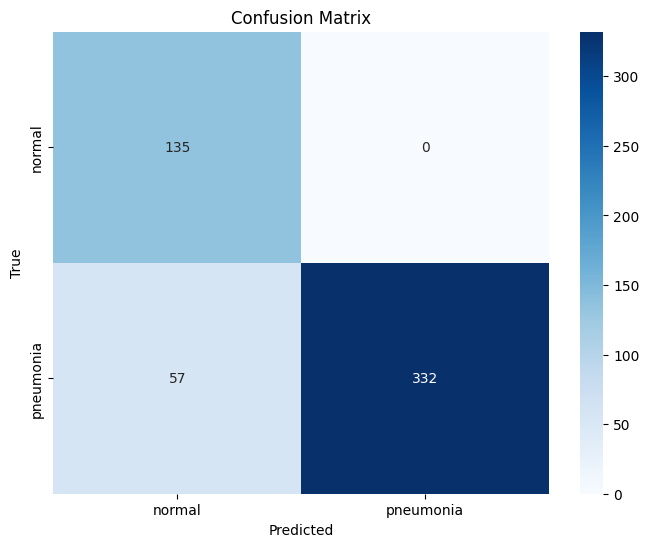

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming conf_matix_sklearn is your confusion matrix from sklearn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matix_sklearn, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Project Work

**Methodology**
The project explored six tasks to understand how different factors affect classification performance:

**Task 1**: Impact of Model Architecture on Classification Performance

**Task 2**: Evaluating the Influence of Loss Functions

**Task 3**: Investigating the Effect of Image Resizing on Classification Accuracy

**Task 4**: Assessing Training Variability in Deep Learning Models

**Task 5**: Exploring the Role of Weight Initialization Strategies

**Task 6**: Generalizability of Medical Image Classification Models to New Datasets



## 1. Changing the model

### [MONAI Models](https://docs.monai.io/en/stable/networks.html)

- Provides an overview of essential building blocks for deep learning models in medical imaging, including various layers, activation functions, and normalization techniques.

- It also showcases how these components can be combined to create powerful network architectures for tasks like classification, segmentation, and generative modeling.

In [ ]:
from monai.networks.nets import ResNet,EfficientNet, DenseNet121

# model = ResNet(spatial_dims=2, in_channels=1, out_channels=2).to(device)
# model = EfficientNet(spatial_dims=2, in_channels=1, out_channels=2).to(device)
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=2).to(device)

### [Torchvision Models](https://pytorch.org/vision/stable/models.html)

1. **Provides a Variety of Pre-trained Models**:  The page lists various  models for image classification, object detection, video classification, and image segmentation,  including popular architectures like ResNet, AlexNet, VGG, and Inception. These pre-trained models can be used directly or fine-tuned for specific tasks.

2. **Offers Flexibility with Weights**:  You can easily load pre-trained weights for these models, and even use a new Multi-weight support API (as of version 0.13) to load different weights into the existing model architectures. This allows for experimentation and customization.

3. **[GitHub repository](https://github.com/pytorch/vision/blob/main/torchvision/models/)**: The source code for all the models are found here.


In [ ]:
!pip show torchvision

Name: torchvision
Version: 0.20.0+cu121
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, pillow, torch
Required-by: fastai, lpips, medmnist, timm


In [ ]:
import torchvision
del model
#Importing mobilenetV3
from torchvision.models import mobilenet_v3_large

# model_mobilenet = mobilenet_v3_small(input_channels=1,out_channels=2)
# print(model_mobilenet)

# Load the pre-trained model
model = mobilenet_v3_large(pretrained=False)

# Modify the first convolutional layer to accept 1 input channel
model.features[0][0] = torch.nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

# Modify the classifier to output 2 classes
model.classifier[3] = torch.nn.Linear(in_features=1280, out_features=2, bias=True)
model.classifier[2] = torch.nn.Dropout(p=0.0, inplace=True)

print(model)
loss_function=DiceCELoss(to_onehot_y=True,lambda_dice=0,lambda_ce=1)
optimizer= torch.optim.Adam(model.parameters(), 1e-3)

In [ ]:
from torchvision.models import mobilenet_v2
del model
# Load the pre-trained model
model = mobilenet_v2(pretrained=False)

# Modify the first convolutional layer to accept 1 input channel
model.features[0][0] = torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

# Modify the classifier to output 2 classes
model.classifier[1] = torch.nn.Linear(in_features=1280, out_features=2, bias=True)
model.classifier[0] = torch.nn.Dropout(p=0.0, inplace=False)
print(model)
loss_function=DiceCELoss(to_onehot_y=True,lambda_dice=0,lambda_ce=1)
optimizer= torch.optim.Adam(model.parameters(), 1e-3)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.


In [ ]:
from torchvision.models import resnet34

model = resnet34(weights=True)
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = torch.nn.Linear(in_features=512, out_features=2, bias=True)
print(model)
loss_function=DiceCELoss(to_onehot_y=True,lambda_dice=0,lambda_ce=1)
optimizer= torch.optim.Adam(model.parameters(), 1e-3)

### Training New Model

In [ ]:
from monai.data import decollate_batch
from sklearn.metrics import accuracy_score
from tqdm import tqdm
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
max_epochs=5
for epoch in range(max_epochs):                                                                   #Iteration of for loop through multiple epochs
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in tqdm(train_loader):                                                                              #Iteration of all the data in train loader
        step += 1
        inputs, labels = batch_data
        inputs = inputs["image"].to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)                                                                                 #Predicting the outputs from the model
        loss = loss_function(outputs, labels)                                                                   #Computing the loss for each batch
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")                                                  #Printing the computed loss after training

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:                                                                         #Iteration of all the data in val loader
                val_images, val_labels = val_data[0]["image"].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)                                                                    #Computing the AUROC metric
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            y_pred_class = torch.argmax(y_pred, dim=1)                          # Convert logits to class labels
            acc_metric = accuracy_score(y.cpu().numpy(),y_pred_class.cpu().numpy())                             # Computing the accuracy
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model_modelchange.pth")
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

----------
epoch 1/5


100%|██████████| 148/148 [00:55<00:00,  2.65it/s]

epoch 1 average loss: 0.3319


saved new best metric model
current epoch: 1 current AUC: 0.9739 current accuracy: 0.9160 best AUC: 0.9739 at epoch: 1
----------
epoch 2/5


100%|██████████| 148/148 [00:53<00:00,  2.76it/s]

epoch 2 average loss: 0.1694


saved new best metric model
current epoch: 2 current AUC: 0.9859 current accuracy: 0.9427 best AUC: 0.9859 at epoch: 2
----------
epoch 3/5


100%|██████████| 148/148 [00:53<00:00,  2.74it/s]

epoch 3 average loss: 0.1670


saved new best metric model
current epoch: 3 current AUC: 0.9892 current accuracy: 0.9542 best AUC: 0.9892 at epoch: 3
----------
epoch 4/5


100%|██████████| 148/148 [01:18<00:00,  1.90it/s]

epoch 4 average loss: 0.1205


saved new best metric model
current epoch: 4 current AUC: 0.9907 current accuracy: 0.9580 best AUC: 0.9907 at epoch: 4
----------
epoch 5/5


100%|██████████| 148/148 [00:53<00:00,  2.74it/s]

epoch 5 average loss: 0.1064


saved new best metric model
current epoch: 5 current AUC: 0.9910 current accuracy: 0.9561 best AUC: 0.9910 at epoch: 5
train completed, best_metric: 0.9910 at epoch: 5


### Evaluation

In [ ]:
# Load the best model
model.load_state_dict(torch.load("/content/best_metric_model_modelchange.pth"))

#Setting the model to evaluation state
model.eval()


with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader:
        val_images, val_labels = val_data[0]["image"].to(device), val_data[1].to(device)
        y_pred = torch.cat([y_pred, model(val_images)], dim=0)
        y = torch.cat([y, val_labels], dim=0)

print(f"The shape of y_pred is: {y_pred.shape}")
y_pred_class = torch.argmax(y_pred,dim=1)
print(f"The shape of y_pred_class is: {y_pred_class.shape}")
print(f"The shape of y_pred_class is: {y_pred_class.unsqueeze(-1).shape}")
accuracy = accuracy_score(y_pred_class.cpu().numpy(),y.squeeze(-1).cpu().numpy())
print(f"Accuracy on validation set: {accuracy}")
y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
y_pred_onehot = [y_trans(i) for i in decollate_batch(y_pred_class.unsqueeze(-1), detach=False)]
y_onehot = torch.stack(y_onehot)
y_pred_onehot = torch.stack(y_pred_onehot)
print(f"The shape of y_pred_onehot is: {y_pred_onehot.shape}")
print(f"The shape of y_onehot is: {y_onehot.shape}")
# print(f"Confusion Matrix:\n{conf_matrix}")
conf_matix_sklearn = confusion_matrix(y,y_pred_class)
# print(f"Confusion Matrix:\n{conf_matix_sklearn}")

from sklearn.metrics import classification_report

print(classification_report(y.cpu().numpy(), y_pred_class.cpu().numpy(), target_names=class_names))

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


The shape of y_pred is: torch.Size([524, 2])
The shape of y_pred_class is: torch.Size([524])
The shape of y_pred_class is: torch.Size([524, 1])
Accuracy on validation set: 0.9561068702290076
The shape of y_pred_onehot is: torch.Size([524, 2])
The shape of y_onehot is: torch.Size([524, 2])
              precision    recall  f1-score   support

      normal       0.92      0.91      0.91       135
   pneumonia       0.97      0.97      0.97       389

    accuracy                           0.96       524
   macro avg       0.94      0.94      0.94       524
weighted avg       0.96      0.96      0.96       524



#### Visualization

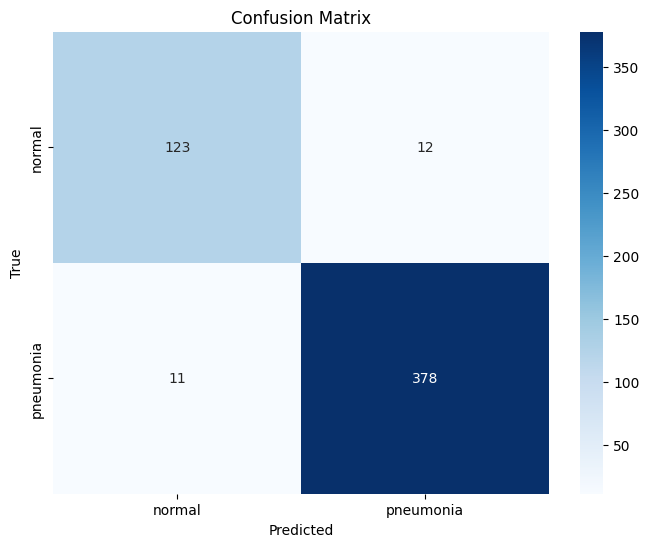

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming conf_matix_sklearn is your confusion matrix from sklearn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matix_sklearn, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## 2. Changing loss function

In [ ]:
#Importing Torch lossses
from torch.nn import CrossEntropyLoss
from torch.nn import BCEWithLogitsLoss
from torch.nn import MultiMarginLoss



In [ ]:
import torch
import torch.nn as nn

# Define batch size and number of classes
batch_size = 32
num_classes = 2

# Generate random tensors
x = torch.rand(batch_size, num_classes)  # Probabilities
y = torch.randint(0, num_classes, (batch_size,))  # Labels

# Print shapes
print("Shape of x:", x.shape)
print("Shape of y:", y.shape)

# Define loss functions
loss_fn_bce = nn.BCELoss()
loss_fn_bce_logits = nn.BCEWithLogitsLoss()
loss_fn_multimargin = nn.MultiMarginLoss()
loss_fn_monai_ce = DiceCELoss(to_onehot_y=True, lambda_dice=0, lambda_ce=1)

loss_bce = loss_fn_bce(torch.sigmoid(x), nn.functional.one_hot(y, num_classes).float())
loss_bce_logits = loss_fn_bce_logits(x, nn.functional.one_hot(y, num_classes).float())
loss_multimargin = loss_fn_multimargin(x, y)
loss_monai_ce = loss_fn_monai_ce(x, y.unsqueeze(-1))

# Print losses
print("BCELoss:", loss_bce)
print("BCEWithLogitsLoss:", loss_bce_logits)
print("MultiMarginLoss:", loss_multimargin)
print("MONAI DiceCELoss:", loss_monai_ce)

Shape of x: torch.Size([32, 2])
Shape of y: torch.Size([32])
BCELoss: tensor(0.7708)
BCEWithLogitsLoss: tensor(0.7708)
MultiMarginLoss: tensor(0.5743)
MONAI DiceCELoss: tensor(0.7894)


In [ ]:
from monai.networks.nets import DenseNet
#Importing FocalLoss from MONAI
from monai.losses import FocalLoss

device= torch.device("cuda" if torch.cuda.is_available() else 'cpu')
if(device == "cpu"): print("using CPU")

model = DenseNet(spatial_dims=2, in_channels=1, out_channels=2).to(device)
loss_function=FocalLoss(to_onehot_y=True)
optimizer= torch.optim.Adam(model.parameters(), 1e-3)
max_epochs=5
val_interval=1
auc_metric = ROCAUCMetric()
class_names = ['normal', 'pneumonia']

from monai.transforms import AsDiscrete, Activations
y_pred_trans = Activations(softmax=True)                          #added y_pred_trans for softmax
y_trans = AsDiscrete(to_onehot=2)                                 #added y_trans for one_hot

### Model & Training

In [ ]:
from monai.data import decollate_batch
from sklearn.metrics import accuracy_score
from tqdm import tqdm
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
max_epochs=5
for epoch in range(max_epochs):                                                                   #Iteration of for loop through multiple epochs
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in tqdm(train_loader):                                                                              #Iteration of all the data in train loader
        step += 1
        inputs, labels = batch_data
        inputs = inputs["image"].to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)                                                                                 #Predicting the outputs from the model
        loss = loss_fn_multimargin(outputs, labels)                                                                   #Computing the loss for each batch
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")                                                  #Printing the computed loss after training

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:                                                                         #Iteration of all the data in val loader
                val_images, val_labels = val_data[0]["image"].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)                                                                    #Computing the AUROC metric
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            y_pred_class = torch.argmax(y_pred, dim=1)                          # Convert logits to class labels
            acc_metric = accuracy_score(y.cpu().numpy(),y_pred_class.cpu().numpy())                             # Computing the accuracy
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model_losfunctionchange.pth")
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

----------
epoch 1/5


  0%|          | 0/148 [00:02<?, ?it/s]


RuntimeError: inconsistent target size, expected 32 but got [32, 1]

### Evaluation

In [ ]:
# Load the best model
model.load_state_dict(torch.load("/content/best_metric_model_losfunctionchange.pth"))

#Setting the model to evaluation state
model.eval()


with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader:
        val_images, val_labels = val_data[0]["image"].to(device), val_data[1].to(device)
        y_pred = torch.cat([y_pred, model(val_images)], dim=0)
        y = torch.cat([y, val_labels], dim=0)

print(f"The shape of y_pred is: {y_pred.shape}")
y_pred_class = torch.argmax(y_pred,dim=1)
print(f"The shape of y_pred_class is: {y_pred_class.shape}")
print(f"The shape of y_pred_class is: {y_pred_class.unsqueeze(-1).shape}")
accuracy = accuracy_score(y_pred_class.cpu().numpy(),y.squeeze(-1).cpu().numpy())
print(f"Accuracy on validation set: {accuracy}")
y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
y_pred_onehot = [y_trans(i) for i in decollate_batch(y_pred_class.unsqueeze(-1), detach=False)]
y_onehot = torch.stack(y_onehot)
y_pred_onehot = torch.stack(y_pred_onehot)
print(f"The shape of y_pred_onehot is: {y_pred_onehot.shape}")
print(f"The shape of y_onehot is: {y_onehot.shape}")
# print(f"Confusion Matrix:\n{conf_matrix}")
conf_matix_sklearn = confusion_matrix(y,y_pred_class)
# print(f"Confusion Matrix:\n{conf_matix_sklearn}")

from sklearn.metrics import classification_report

print(classification_report(y.cpu().numpy(), y_pred_class.cpu().numpy(), target_names=class_names))

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


The shape of y_pred is: torch.Size([524, 2])
The shape of y_pred_class is: torch.Size([524])
The shape of y_pred_class is: torch.Size([524, 1])
Accuracy on validation set: 0.9713740458015268
The shape of y_pred_onehot is: torch.Size([524, 2])
The shape of y_onehot is: torch.Size([524, 2])
              precision    recall  f1-score   support

      normal       0.95      0.93      0.94       135
   pneumonia       0.98      0.98      0.98       389

    accuracy                           0.97       524
   macro avg       0.97      0.96      0.96       524
weighted avg       0.97      0.97      0.97       524



#### Visualization

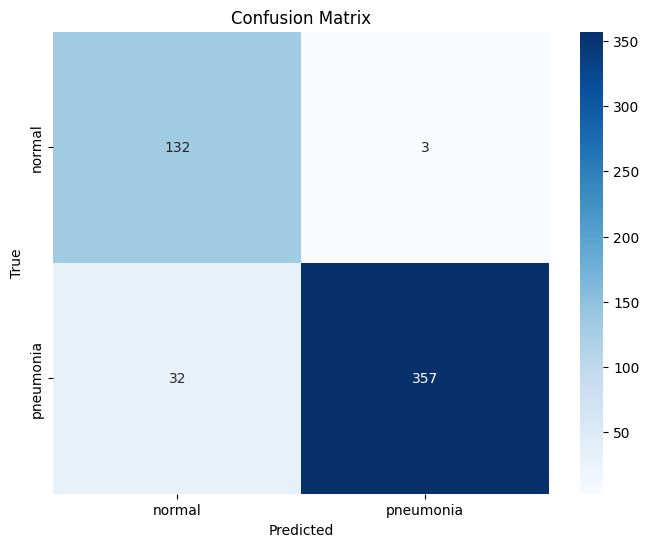

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming conf_matix_sklearn is your confusion matrix from sklearn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matix_sklearn, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## 3. Changing image dimensions

### Transforms

In [ ]:
from monai.transforms import (
    Compose,
    LoadImaged,  # Import LoadImaged for dictionary-based input
    RandRotate,
    RandFlip,
    ToTensor,
    EnsureChannelFirstd, # Use EnsureChannelFirstd to work with dictionary
    ScaleIntensityd, # Use ScaleIntensityd to work with dictionary
    EnsureTyped, # Add this
    Resized,
    BorderPadd
)
from monai.data import Dataset, NumpyReader

# Define transforms for training data
train_transforms = Compose([
    ToTensor(),
    EnsureChannelFirstd(keys=['image'], channel_dim="no_channel"),  # Add channel dimension to the image data using the 'image' key
    ScaleIntensityd(keys=['image']),  # Rescale image pixel values using the 'image' key
    EnsureTyped(keys=['image']),
    Resized(keys=["image"],spatial_size=(60,60)),
    BorderPadd(keys=["image"],spatial_border=[2,2]),
])

train_ds = Dataset(data=train_dataset, transform=train_transforms)
train_label = np.load('/content/pneumoniamnist/train_labels.npy')
train_label = ToTensor()(train_label)



val_images = np.load('/content/pneumoniamnist/val_images.npy')
val_labels = np.load('/content/pneumoniamnist/val_labels.npy')

val_files = [{'image': img} for img in val_images]

val_transforms = Compose([
    ToTensor(),
    EnsureChannelFirstd(keys=['image'], channel_dim="no_channel"),
    ScaleIntensityd(keys=['image']),
    EnsureTyped(keys=['image']),
    Resized(keys=["image"],spatial_size=(60,60)),
    BorderPadd(keys=["image"],spatial_border=[2,2]),
])

val_ds = Dataset(data=val_files, transform=val_transforms)
val_label = np.load('/content/pneumoniamnist/val_labels.npy')
val_label = ToTensor()(val_label)

In [ ]:
print(f"The length of train dataset is: {len(train_ds)}")
print(f"The size of the image is: {train_ds[0]['image'].shape} with type {type(train_ds[0]['image'])}")
print(f"The size of the label is: {train_label.shape} with type {type(train_label)}")
print(f"The length of val dataset is: {len(val_ds)}")
print(f"The size of the image is: {val_ds[0]['image'].shape} with type {type(val_ds[0]['image'])}")
print(f"The size of the label is: {val_label.shape} with type {type(val_label)}")

The length of train dataset is: 4708
The size of the image is: torch.Size([1, 64, 64]) with type <class 'monai.data.meta_tensor.MetaTensor'>
The size of the label is: torch.Size([4708, 1]) with type <class 'monai.data.meta_tensor.MetaTensor'>
The length of val dataset is: 524
The size of the image is: torch.Size([1, 64, 64]) with type <class 'monai.data.meta_tensor.MetaTensor'>
The size of the label is: torch.Size([524, 1]) with type <class 'monai.data.meta_tensor.MetaTensor'>


### DataLoader

In [ ]:
train_loader = DataLoader(
    dataset=list(zip(train_ds, train_label)),  # Use zip to create pairs of (image, label)
    batch_size=32,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    dataset=list(zip(val_ds, val_label)),
    batch_size=32,
    shuffle=False,
    num_workers=2
)

### Model & Training

In [ ]:
from monai.networks.nets import DenseNet
from monai.losses import DiceCELoss
from monai.metrics import ROCAUCMetric
import sklearn
del model
device= torch.device("cuda" if torch.cuda.is_available() else 'cpu')
if(device == "cpu"): print("using CPU")

model = DenseNet(spatial_dims=2, in_channels=1, out_channels=2).to(device)
loss_function=DiceCELoss(to_onehot_y=True,lambda_dice=0,lambda_ce=1)
optimizer= torch.optim.Adam(model.parameters(), 1e-3)
max_epochs=1
val_interval=1
auc_metric = ROCAUCMetric()
class_names = ['normal', 'pneumonia']

from monai.transforms import AsDiscrete, Activations
y_pred_trans = Activations(softmax=True)                          #added y_pred_trans for softmax
y_trans = AsDiscrete(to_onehot=2)                                 #added y_trans for one_hot

Training

In [ ]:
from monai.data import decollate_batch
from sklearn.metrics import accuracy_score
from tqdm import tqdm
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
max_epochs=5


for epoch in range(max_epochs):                                                                   #Iteration of for loop through multiple epochs
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in tqdm(train_loader):                                                                              #Iteration of all the data in train loader
        step += 1
        inputs, labels = batch_data
        inputs = inputs["image"].to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)                                                                                 #Predicting the outputs from the model
        loss = loss_function(outputs, labels)                                                                   #Computing the loss for each batch
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")                                                  #Printing the computed loss after training

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:                                                                         #Iteration of all the data in val loader
                val_images, val_labels = val_data[0]["image"].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)                                                                    #Computing the AUROC metric
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            y_pred_class = torch.argmax(y_pred, dim=1)                          # Convert logits to class labels
            acc_metric = accuracy_score(y.cpu().numpy(),y_pred_class.cpu().numpy())                             # Computing the accuracy
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model_imageresize.pth")
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

----------
epoch 1/5


100%|██████████| 148/148 [05:48<00:00,  2.35s/it]

epoch 1 average loss: 0.1820


saved new best metric model
current epoch: 1 current AUC: 0.9924 current accuracy: 0.9523 best AUC: 0.9924 at epoch: 1
----------
epoch 2/5


  1%|▏         | 2/148 [00:08<10:17,  4.23s/it]


KeyboardInterrupt: 

### Evaluation

In [ ]:
# Load the best model
model.load_state_dict(torch.load("/content/best_metric_model_imageresize.pth"))

#Setting the model to evaluation state
model.eval()


with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader:
        val_images, val_labels = val_data[0]["image"].to(device), val_data[1].to(device)
        y_pred = torch.cat([y_pred, model(val_images)], dim=0)
        y = torch.cat([y, val_labels], dim=0)

print(f"The shape of y_pred is: {y_pred.shape}")
y_pred_class = torch.argmax(y_pred,dim=1)
print(f"The shape of y_pred_class is: {y_pred_class.shape}")
print(f"The shape of y_pred_class is: {y_pred_class.unsqueeze(-1).shape}")
accuracy = accuracy_score(y_pred_class.cpu().numpy(),y.squeeze(-1).cpu().numpy())
print(f"Accuracy on validation set: {accuracy}")
y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
y_pred_onehot = [y_trans(i) for i in decollate_batch(y_pred_class.unsqueeze(-1), detach=False)]
y_onehot = torch.stack(y_onehot)
y_pred_onehot = torch.stack(y_pred_onehot)
print(f"The shape of y_pred_onehot is: {y_pred_onehot.shape}")
print(f"The shape of y_onehot is: {y_onehot.shape}")

# print(f"Confusion Matrix:\n{conf_matrix}")
conf_matix_sklearn = confusion_matrix(y,y_pred_class)
# print(f"Confusion Matrix:\n{conf_matix_sklearn}")

from sklearn.metrics import classification_report

print(classification_report(y.cpu().numpy(), y_pred_class.cpu().numpy(), target_names=class_names))

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


The shape of y_pred is: torch.Size([524, 2])
The shape of y_pred_class is: torch.Size([524])
The shape of y_pred_class is: torch.Size([524, 1])
Accuracy on validation set: 0.9522900763358778
The shape of y_pred_onehot is: torch.Size([524, 2])
The shape of y_onehot is: torch.Size([524, 2])
              precision    recall  f1-score   support

      normal       0.92      0.90      0.91       135
   pneumonia       0.96      0.97      0.97       389

    accuracy                           0.95       524
   macro avg       0.94      0.93      0.94       524
weighted avg       0.95      0.95      0.95       524



#### Visualization

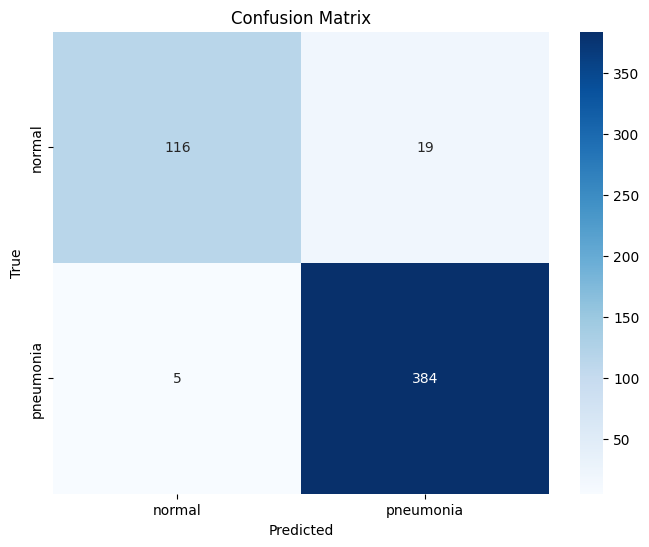

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming conf_matix_sklearn is your confusion matrix from sklearn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matix_sklearn, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## 4. Observe Training Variability

The first code has to be run three times to understand the variability in the performance on the model during three different runs

## 5. Changing weight initialization

### Transforms

In [ ]:
from monai.transforms import (
    Compose,
    LoadImaged,  # Import LoadImaged for dictionary-based input
    RandRotate,
    RandFlip,
    ToTensor,
    EnsureChannelFirstd, # Use EnsureChannelFirstd to work with dictionary
    ScaleIntensityd, # Use ScaleIntensityd to work with dictionary
    EnsureTyped, # Add this
    Resized,
    BorderPadd # Use BorderPadd for dictionary-based input
)
from monai.data import Dataset, NumpyReader

# Define transforms for training data
train_transforms = Compose([
    ToTensor(),
    EnsureChannelFirstd(keys=['image'], channel_dim="no_channel"),  # Add channel dimension to the image data using the 'image' key
    ScaleIntensityd(keys=['image']),  # Rescale image pixel values using the 'image' key
    EnsureTyped(keys=['image']),
    # Resized(keys=["image"],spatial_size=(32,32)),
    BorderPadd(keys=["image"],spatial_border=[2, 2]), # Use a list of two integers for padding (height, width) or a single integer for both.
    ToTensor(),
])

train_ds = Dataset(data=train_dataset, transform=train_transforms)
train_label = np.load('/content/pneumoniamnist/train_labels.npy')
train_label = ToTensor()(train_label)

In [ ]:
print(f"The length of train dataset is: {len(train_ds)}")
print(f"The size of the image is: {train_ds[0]['image'].shape} with type {type(train_ds[0]['image'])}")
print(f"The size of the label is: {train_label.shape} with type {type(train_label)}")

The length of train dataset is: 4708
The size of the image is: torch.Size([1, 32, 32]) with type <class 'monai.data.meta_tensor.MetaTensor'>
The size of the label is: torch.Size([4708, 1]) with type <class 'monai.data.meta_tensor.MetaTensor'>


In [ ]:
val_images = np.load('/content/pneumoniamnist/val_images.npy')
val_labels = np.load('/content/pneumoniamnist/val_labels.npy')

val_files = [{'image': img} for img in val_images]

val_transforms = Compose([
    ToTensor(),
    EnsureChannelFirstd(keys=['image'], channel_dim="no_channel"),
    ScaleIntensityd(keys=['image']),
    EnsureTyped(keys=['image']),
    # Resized(keys=["image"],spatial_size=(32,32)),
    BorderPadd(keys=["image"],spatial_border=[2,2]), # Changed BorderPad to BorderPadd
])

val_ds = Dataset(data=val_files, transform=val_transforms)
val_label = np.load('/content/pneumoniamnist/val_labels.npy')
val_label = ToTensor()(val_label)

In [ ]:
print(f"The length of val dataset is: {len(val_ds)}")
print(f"The size of the image is: {val_ds[0]['image'].shape} with type {type(val_ds[0]['image'])}")
print(f"The size of the label is: {val_label.shape} with type {type(val_label)}")

The length of val dataset is: 524
The size of the image is: torch.Size([1, 32, 32]) with type <class 'monai.data.meta_tensor.MetaTensor'>
The size of the label is: torch.Size([524, 1]) with type <class 'monai.data.meta_tensor.MetaTensor'>


### DataLoader

In [ ]:
train_loader = DataLoader(
    dataset=list(zip(train_ds, train_label)),  # Use zip to create pairs of (image, label)
    batch_size=32,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    dataset=list(zip(val_ds, val_label)),
    batch_size=32,
    shuffle=False,
    num_workers=2
)

### Model parameters

#### Transfer Learning weight initialization

In [ ]:
from monai.networks.nets import DenseNet121
from monai.losses import DiceCELoss
from monai.metrics import ROCAUCMetric
import sklearn
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=2,pretrained=True).to(device)


#### Kaiming Initialization

In [ ]:
del model
model = DenseNet(spatial_dims=2, in_channels=1, out_channels=2).to(device)
from torch.nn import init
# Apply Kaiming initialization to convolutional layers
for m in model.modules():
    if isinstance(m, torch.nn.Conv2d):
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')  # Adjust nonlinearity if needed
        if m.bias is not None:
            init.constant_(m.bias, 0)

#### Random Initialization

In [ ]:
del model
model = DenseNet(spatial_dims=2, in_channels=1, out_channels=2).to(device)
from torch.nn import init
# Apply random initialization to convolutional layers
for m in model.modules():
    if isinstance(m, torch.nn.Conv2d):
        init.xavier_uniform_(m.weight)  # Or init.uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0)

Other initializations

In [ ]:
loss_function=DiceCELoss(to_onehot_y=True,lambda_dice=0,lambda_ce=1)
optimizer= torch.optim.Adam(model.parameters(), 1e-3)
max_epochs=1
val_interval=1
auc_metric = ROCAUCMetric()
class_names = ['normal', 'pneumonia']

from monai.transforms import AsDiscrete, Activations
y_pred_trans = Activations(softmax=True)                          #added y_pred_trans for softmax
y_trans = AsDiscrete(to_onehot=2)                                 #added y_trans for one_hot

### Training the model

In [ ]:
from monai.data import decollate_batch
from sklearn.metrics import accuracy_score
from tqdm import tqdm
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []



for epoch in range(max_epochs):                                                                   #Iteration of for loop through multiple epochs
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in tqdm(train_loader):                                                                              #Iteration of all the data in train loader
        step += 1
        inputs, labels = batch_data
        inputs = inputs["image"].to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)                                                                                 #Predicting the outputs from the model
        loss = loss_function(outputs, labels)                                                                   #Computing the loss for each batch
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")                                                  #Printing the computed loss after training

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:                                                                         #Iteration of all the data in val loader
                val_images, val_labels = val_data[0]["image"].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)                                                                    #Computing the AUROC metric
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            y_pred_class = torch.argmax(y_pred, dim=1)                          # Convert logits to class labels
            acc_metric = accuracy_score(y.cpu().numpy(),y_pred_class.cpu().numpy())                             # Computing the accuracy
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model_initialization.pth")
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

----------
epoch 1/1


100%|██████████| 148/148 [05:07<00:00,  2.08s/it]

epoch 1 average loss: 0.1796


saved new best metric model
current epoch: 1 current AUC: 0.9900 current accuracy: 0.8111 best AUC: 0.9900 at epoch: 1
train completed, best_metric: 0.9900 at epoch: 1


### Evaluation

In [ ]:
# Load the best model
model.load_state_dict(torch.load("/content/best_metric_model_initialization.pth"))

#Setting the model to evaluation state
model.eval()


with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader:
        val_images, val_labels = val_data[0]["image"].to(device), val_data[1].to(device)
        y_pred = torch.cat([y_pred, model(val_images)], dim=0)
        y = torch.cat([y, val_labels], dim=0)

print(f"The shape of y_pred is: {y_pred.shape}")
y_pred_class = torch.argmax(y_pred,dim=1)
print(f"The shape of y_pred_class is: {y_pred_class.shape}")
print(f"The shape of y_pred_class is: {y_pred_class.unsqueeze(-1).shape}")
accuracy = accuracy_score(y_pred_class.cpu().numpy(),y.squeeze(-1).cpu().numpy())
print(f"Accuracy on validation set: {accuracy}")
y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
y_pred_onehot = [y_trans(i) for i in decollate_batch(y_pred_class.unsqueeze(-1), detach=False)]
y_onehot = torch.stack(y_onehot)
y_pred_onehot = torch.stack(y_pred_onehot)
print(f"The shape of y_pred_onehot is: {y_pred_onehot.shape}")
print(f"The shape of y_onehot is: {y_onehot.shape}")

# print(f"Confusion Matrix:\n{conf_matrix}")
conf_matix_sklearn = confusion_matrix(y,y_pred_class)
# print(f"Confusion Matrix:\n{conf_matix_sklearn}")

from sklearn.metrics import classification_report

print(classification_report(y.cpu().numpy(), y_pred_class.cpu().numpy(), target_names=class_names))

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


The shape of y_pred is: torch.Size([524, 2])
The shape of y_pred_class is: torch.Size([524])
The shape of y_pred_class is: torch.Size([524, 1])
Accuracy on validation set: 0.8110687022900763
The shape of y_pred_onehot is: torch.Size([524, 2])
The shape of y_onehot is: torch.Size([524, 2])
              precision    recall  f1-score   support

      normal       0.58      1.00      0.73       135
   pneumonia       1.00      0.75      0.85       389

    accuracy                           0.81       524
   macro avg       0.79      0.87      0.79       524
weighted avg       0.89      0.81      0.82       524



#### Visualization

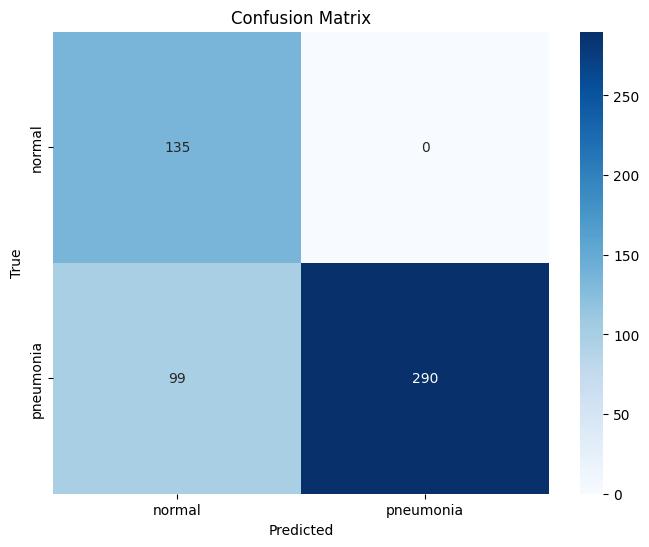

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming conf_matix_sklearn is your confusion matrix from sklearn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matix_sklearn, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## 6. Generalizability

In [ ]:
from medmnist import ChestMNIST

In [ ]:
data_test = ChestMNIST(root = '/content/',split='test', download=True)

100%|██████████| 82.8M/82.8M [00:20<00:00, 3.97MB/s]


In [ ]:
print(data_test.info)

{'python_class': 'ChestMNIST', 'description': 'The ChestMNIST is based on the NIH-ChestXray14 dataset, a dataset comprising 112,120 frontal-view X-Ray images of 30,805 unique patients with the text-mined 14 disease labels, which could be formulized as a multi-label binary-class classification task. We use the official data split, and resize the source images of 1×1024×1024 into 1×28×28.', 'url': 'https://zenodo.org/records/10519652/files/chestmnist.npz?download=1', 'MD5': '02c8a6516a18b556561a56cbdd36c4a8', 'url_64': 'https://zenodo.org/records/10519652/files/chestmnist_64.npz?download=1', 'MD5_64': '9de6cd0b934ebb5b7426cfba5efbae16', 'url_128': 'https://zenodo.org/records/10519652/files/chestmnist_128.npz?download=1', 'MD5_128': 'db107e5590b27930b62dbaf558aebee3', 'url_224': 'https://zenodo.org/records/10519652/files/chestmnist_224.npz?download=1', 'MD5_224': '45bd33e6f06c3e8cdb481c74a89152aa', 'task': 'multi-label, binary-class', 'label': {'0': 'atelectasis', '1': 'cardiomegaly', '2'

In [ ]:
!unzip /content/chestmnist.npz -d /content/chestmnist

Archive:  /content/chestmnist.npz
  inflating: /content/chestmnist/train_images.npy  
  inflating: /content/chestmnist/val_images.npy  
  inflating: /content/chestmnist/test_images.npy  
  inflating: /content/chestmnist/train_labels.npy  
  inflating: /content/chestmnist/val_labels.npy  
  inflating: /content/chestmnist/test_labels.npy  


In [ ]:
import numpy as np
import torch
from monai.networks.nets import DenseNet
from monai.transforms import Activations, AsDiscrete
from monai.data import decollate_batch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load test data and labels
test_images = np.load('/content/chestmnist/val_images.npy')
test_labels = np.load('/content/chestmnist/val_labels.npy')

# Assuming you have a suitable transform for test data (similar to val_transforms)
test_files = [{'image': i} for i in test_images]

test_transforms = Compose([
    ToTensor(),
    EnsureChannelFirstd(keys=['image'], channel_dim="no_channel"),
    ScaleIntensityd(keys=['image']),
    EnsureTyped(keys=['image']),
    # Resized(keys=["image"],spatial_size=(32,32)),
    BorderPadd(keys=["image"],spatial_border=[2,2]), # Changed BorderPad to BorderPadd
    ToTensor(),
])



In [ ]:
# prompt: print the min and max of the test_label array
print(f"Shape of the test_images: {test_images.shape}")
print(f"Shape of test_labels: {test_labels.shape}")
print(f"Min of test_labels: {np.min(test_labels)}")
print(f"Max of test_labels: {np.max(test_labels)}")

Shape of the test_images: torch.Size([19, 1, 32, 32])
Shape of test_labels: torch.Size([19, 1])
Min of test_labels: 0
Max of test_labels: 0


In [ ]:
new_test_labels = np.zeros((test_labels.shape[0], 1), dtype=int)

for i in range(test_labels.shape[0]):
    # Iterate through each element in the row of test_labels
    # and set the corresponding value in new_test_labels based on the condition
    for j in range(test_labels.shape[1]):
        if test_labels[i][j] == 1 and j == 6:         # Check if the element is 1 and at index 6
            new_test_labels[i] = 1  # Column 1 (position '6')
            break # Exit the loop to go to the next row of test_labels

    for j in range(test_labels.shape[1]):
        if test_labels[i][j] == 1 and j == 7:         # Check if the element is 1 and at index 7
            new_test_labels[i] = 1  # Column 1 (position '6')
            break # Exit the loop to go to the next row of test_labels

print(f"Shape of the new test labels: {new_test_labels.shape}")
# You can now save new_test_labels to a file if needed
# np.save('new_test_labels.npy', new_test_labels)

Shape of the new test labels: (19, 1)


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


The shape of y_pred is: torch.Size([11219, 2])
The shape of y is: torch.Size([11219, 1])
              precision    recall  f1-score   support

      Normal       0.99      0.84      0.91     11086
   Pneumonia       0.02      0.30      0.04       133

    accuracy                           0.84     11219
   macro avg       0.51      0.57      0.48     11219
weighted avg       0.98      0.84      0.90     11219



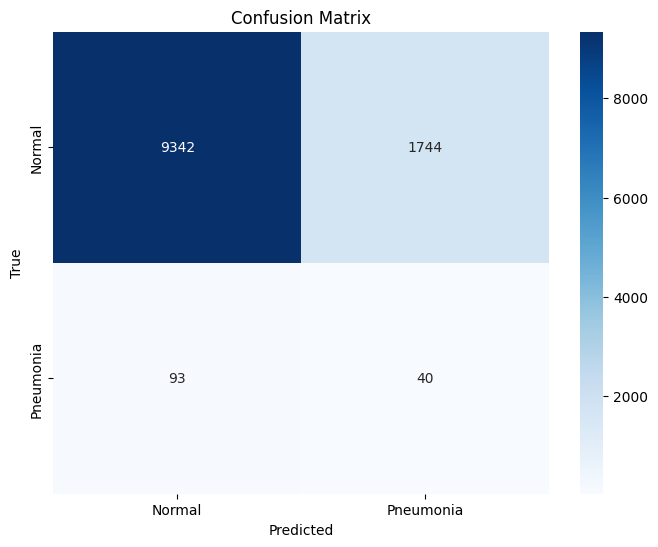

In [ ]:
test_ds = Dataset(data=test_files, transform=test_transforms)

test_label = ToTensor()(new_test_labels)


test_loader = DataLoader(
    dataset=list(zip(test_ds, test_label)),
    batch_size=32,  # Adjust batch size as needed
    shuffle=False,
    num_workers=2
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet(spatial_dims=2, in_channels=1, out_channels=2).to(device)
model.load_state_dict(torch.load("/content/best_metric_model.pth"))
model.eval()

y_pred_trans = Activations(softmax=True)
y_trans = AsDiscrete(to_onehot=2)
class_names = ['Normal', 'Pneumonia']

with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for test_data in test_loader:
        test_images, test_labels = test_data[0]["image"].to(device), test_data[1].to(device)
        y_pred = torch.cat([y_pred, model(test_images)], dim=0)
        y = torch.cat([y, test_labels], dim=0)

print(f"The shape of y_pred is: {y_pred.shape}")
print(f"The shape of y is: {y.shape}")
y_pred_class = torch.argmax(y_pred, dim=1)

print(classification_report(y.cpu().numpy(), y_pred_class.cpu().numpy(), target_names=class_names))

conf_matrix = confusion_matrix(y.cpu().numpy(), y_pred_class.cpu().numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()